In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# torch modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


# my modules 
from DataClass import *

from sklearn.model_selection import train_test_split


In [152]:
ticker_tag = 'TSLA'
dc = StockData(ticker = ticker_tag, start = '2012-01-01', end = '2022-08-01', interval='1d')

D:\Documents\Coding\Python\ML exploration\ANN\stocks-modeling\DataClass.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Increases'][self.data['next growth'] > 1] = 1


In [153]:
#dc.data.columns
dc.data.head()

,Open,High,Low,Close,Volume,prev growth,next growth,Increases,30 MA,10 MA
Date,,,,,,,,,,
2012-01-03,1.929333,1.966666,1.843333,1.872000,13920780,NaN,0.986823,0,NaN,NaN
2012-01-04,1.880666,1.911333,1.833333,1.847333,9450540,0.986823,0.978708,0,NaN,NaN
2012-01-05,1.850666,1.862000,1.790000,1.808000,15081480,0.978708,0.992257,0,NaN,NaN
2012-01-06,1.813333,1.852666,1.760666,1.794000,14794305,0.992257,1.012634,1,NaN,NaN
2012-01-09,1.800000,1.832666,1.741333,1.816666,13454265,1.012634,1.013578,1,NaN,NaN


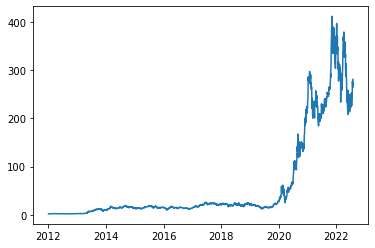

In [154]:
plt.plot(dc.data.index, dc.data['Open'])


In [155]:
# Data Preps for NN

nn_data = dc.data[['Open', 'High', 'Low', 'Close', 'prev growth', 'next growth', '30 MA', '10 MA','Increases']]
nn_data.dropna(inplace=True)
nn_data = torch.tensor(nn_data.values, dtype = torch.float)
#nn_data = torch.unsqueeze(nn_data, 1) # adds dimension


# split data into training & test datasets
training_data, test_data = train_test_split(nn_data, test_size= 0.2, train_size= 0.8)

training_X, training_Y = training_data[:,:8], training_data[:,8]
training_Y = torch.unsqueeze(training_Y, 1) # adds dimension
training_data = TensorDataset(training_X, training_Y)

test_X, test_Y = test_data[:,:8], test_data[:,8]
test_Y = torch.unsqueeze(test_Y, 1) # adds dimension
test_data = TensorDataset(test_X, test_Y)
# I think I need to increase the datasets dimension

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

C:\Users\Adam\AppData\Local\Temp\ipykernel_8900\1680061895.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nn_data.dropna(inplace=True)


In [156]:
# basic NN

class ANN(nn.Module):
    
    def __init__(self, input_size):
        super(ANN, self).__init__()
        
        # simple 3 layer model
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            )
        
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 1)

    def forward(self, x):
        #x = self.linear_relu_stack(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.sigmoid(self.layer3(x))
        return x
    
    
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [157]:
# Paramaters

input_size = nn_data.size()[1] - 1 # number of factors from my df
# num_classes = 1
learning_rate = 0.001
batch_size = 64
num_epochs = 1


# Intialise network
model = ANN(input_size = input_size).to(device)


# Loss and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [161]:
def train_nn(dataloader, model, loss_fn, optimizer):
    "Trains the trains data on Neural Network"
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        
        #print("X is: ",X)
        #print("y is: ",y)
        
        pred = model(X) 
        #print(pred)

        
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



In [184]:
def test_nn(dataloader, model, loss_fn, epoch):
    "Tests the test data on Neural Network"
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, incorrect = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            
            #pred = torch.tensor(np.where(pred > 0.5, 1, 0))
            
           
            test_loss += loss_fn(pred, y).item()
            
            incorrect += ( abs(pred.round() - y) ).sum()

    if epoch % 50 == 0:
        test_loss /= num_batches
        correct = 1 - incorrect / size
        print(f"Test Error (Epoch: {epoch}): \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [185]:
# Train network
num_epochs = 1

for epoch in range(num_epochs):
    
    # train network
    train_nn(train_dataloader, model, loss_fn, optimizer)
    
    # test network - on current epoch
    test_nn(test_dataloader, model, loss_fn, epoch)
    
    
    

Pred  tensor([[1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]]) Y  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0